# Sprint5課題 機械学習スクラッチSVM
分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。<br>
<br>
SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。<br>
<br>
以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。

## 【問題1】ラグランジュの未定乗数法による最急降下

SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数$\lambda$を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

ここで$k(x_i, x_j)$はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分はメソッド化しておきましょう。

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

条件として、更新毎に$\lambda_i \ge 0$を満たす必要があります。満たさない場合は$\lambda_i = 0$とします。<br>

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数$\lambda$が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。<br>
<br>
閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた$y(x)$の符号が分類結果です。
$$
y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n)
$$

## これまでのまとめ
SVMによるマージン最大化問題が以下の式の双対表現に帰着できることは、上記の説明と講義で理解されたかと思います。
$$
\mathrm{argmin}_{w,b}\frac{1}{2}||w||^2
$$
この制約付き最小化問題を解くために、ラグランジュ乗数$\lambda$を導入し、wとbの制約条件を用いて、$\theta$
と$\theta_0$を消去すれば
$$
L(\lambda) = \sum_{i=1}^{n} \lambda_i -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y_{i}y_{j}x_i^Tx_j
$$
という関数が得られ、この関数を$\lambda$に対して最大化すれば良いのでした。この$\lambda$の最適解を求める方法はみなさんがこれまでに学習してきた勾配降下法を用いれば良いわけです。$\lambda$がわかれば$\theta$と$\theta_0$が求まるので、分類境界線が求まります。<br>
<br>
以下の図は、SVMを実装するフローを示したものです。実装の際に参考にしてください。<br>
![image](SVM summary.png)

In [4]:
import numpy as np
import pandas as pd

In [61]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（poly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter=100, lr=0.1, kernel='linear', threshold=1e-5, gamma=1, theta=1, deg=2, verbose=False):
        # ハイパーパラメータを属性として記録
        self.num_iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma_ = gamma
        self.theta_ = theta
        self.deg_ = deg
        self.loss = np.zeros(self.num_iter)
        self.labels_ = None
        
        self.n_support_vectors = None
        self.index_support_vectors = None
        self.X_sv = None
        self.lam_sv = None
        self.y_sv = None
    
    
    def _kernel_func(self, X1, X2):
        """
        線形または多項式カーネル関数の計算を行う

        Parameters
        ----------
        X1 : 次の形のndarray, shape (i_samples, n_features)
            特徴量データ
        X2 : 次の形のndarray, shape (j_samples, n_features )
            特徴量データ

        Returns
        -------
        kernel : 次の形のndarray, shape (i_samples, j_samples)
            カーネル関数にて計算された行列
        """
        
        if self.kernel == 'linear':
            gamma = 1
            theta = 0
            deg = 1
            
        elif self.kernel == 'poly':
            gamma = self.gamma_
            theta = self.theta_
            deg = self.deg_
        
        kernel = (gamma*X1 @ X2.T + theta)**deg
        
        return kernel
    
    
    def _gradient_ascent(self, X, y):
        """
        最急降下法によりパラメータの更新を行う

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
        self.lambda_ : 次の形のndarray, shape (n_features, 1)
            最急降下法により更新されたλ
        """

        kernel = self._kernel_func(X, X)

        self.lambda_ += self.lr * (1 - y*np.dot((self.lambda_*y), kernel))
        
        return self.lambda_
    
    
    def fit(self, X, y):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        
        # 目的変数のラベルを取得し、バイナリ（+1, -1）に変換した配列を作成
        # 以後、計算はy_indicesを用いて行う
        self.labels_ = np.unique(y)
        y_indices = np.where(y == self.labels_[0], -1, 1)

        # λの初期値を設定
        self.lambda_ = np.random.normal(size=len(X))

        for i in range(self.num_iter):

            self.lambda_ = self._gradient_ascent(X, y_indices)
            self.lambda_ = np.where(self.lambda_ < 0, 0, self.lambda_)
            self.loss[i] = self._cost_function(X, y_indices)

        self.n_support_vectors = sum(i > self.threshold for i in self.lambda_)
        self.index_support_vectors = np.where(self.lambda_ > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self.lambda_[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)

            
    def _cost_function(self, X, y):
        """
        目的関数の計算

        Parameters
        ----------
        pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
          number >= 0
          ラグランジュ関数
        """

        loss = sum(self.lambda_) - 0.5 * sum(np.dot(self.lambda_*y, (self.lambda_*y).T)*(X@X.T))

        return max(loss)
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        kernel = self._kernel_func(self.X_sv, X)
        
        pred = np.dot(self.lam_sv * self.y_sv,
                      kernel)
        
        return np.where(pred < 0, self.labels_[0], self.labels_[1])

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [25]:
# シンプルデータセット1作成コード

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [51]:
# 評価指標の読み込みおよび関数化
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_scores(y_true, y_pred):
    print("-"*20)
    print("正解率：{:.2f}".format(accuracy_score(y_true, y_pred)))
    print("適合率：{:.2f}".format(precision_score(y_true, y_pred)))
    print("再現率：{:.2f}".format(recall_score(y_true, y_pred)))
    print("F1値：{:.2f}".format(f1_score(y_true, y_pred)))
    print("-"*20)
    print("\n")

In [52]:
# データの分割（今回は7：3の割合）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print(X_train.shape)
print(y_train.shape)

(350, 2)
(350,)


In [56]:
from sklearn.svm import SVC

# スクラッチモデルの学習と推定
scratch_svc = ScratchSVMClassifier(lr=0.001, num_iter=1000)

scratch_svc.fit(X_train, y_train)

scratch_pred = scratch_svc.predict(X_test)

print("スクラッチモデルの成績")
get_scores(y_test, scratch_pred)

# sklearnモデルの学習と推定
sk_svc = SVC()

sk_svc.fit(X_train, y_train)

sk_pred = sk_svc.predict(X_test)

print("sklearnモデルの成績")
get_scores(y_test, sk_pred)

スクラッチモデルの成績
--------------------
正解率：1.00
適合率：1.00
再現率：1.00
F1値：1.00
--------------------


sklearnモデルの成績
--------------------
正解率：1.00
適合率：1.00
再現率：1.00
F1値：1.00
--------------------




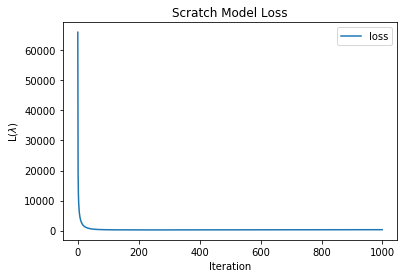

In [57]:
# ラグランジュ関数の可視化
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()

plt.plot(np.arange(len(scratch_svc.loss)), scratch_svc.loss, label='loss')
plt.title("Scratch Model Loss")
plt.xlabel("Iteration")
plt.ylabel("L($\lambda$)")
plt.legend()

plt.show()

## 【問題5】決定領域の可視化
決定領域を可視化してください。<br>
<br>
以下の例のようにサポートベクターは異なる色で示してください。

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, sv, target_names, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel'):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.scatter(sv[:, 0], sv[:, 1], color='yellow', label='SV', marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

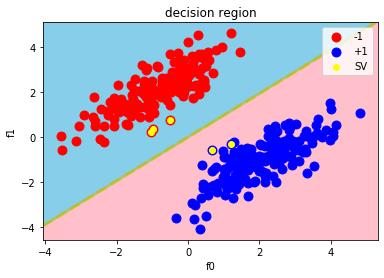

In [58]:
# スクラッチモデルの可視化
decision_region(X_train, y_train, scratch_svc, 
                sv=scratch_svc.X_sv, xlabel='f0', ylabel='f1', target_names=['-1', '+1'])

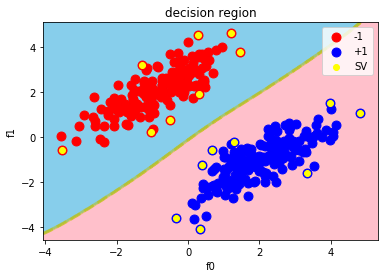

In [59]:
# sklearnモデルの可視化
decision_region(X_train, y_train, sk_svc, 
                sv=sk_svc.support_vectors_, xlabel='f0', ylabel='f1', target_names=['-1', '+1'])

## 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。<br>
<br>
**「線形カーネルの式」**
$$
k(x_i, x_j) = x_{i}^{T} x_j
$$
**「多項式カーネルの式」**
$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$

$\gamma$, $\theta_0$, $d$はハイパーパラメータです。

線形カーネルは$\gamma=1$, $\theta_0=0$, $d=1$の場合の多項式カーネルと等しいと言えます。

In [68]:
# スクラッチモデルの学習と推定
scratch_svc = ScratchSVMClassifier(kernel='poly', lr=0.0001, deg=2)

scratch_svc.fit(X_train, y_train)

scratch_pred = scratch_svc.predict(X_test)

print("多項式スクラッチモデルの成績")
get_scores(y_test, scratch_pred)

# sklearnモデルの学習と推定
sk_svc = SVC(kernel='poly')

sk_svc.fit(X_train, y_train)

sk_pred = sk_svc.predict(X_test)

print("多項式sklearnモデルの成績")
get_scores(y_test, sk_pred)

多項式スクラッチモデルの成績
--------------------
正解率：1.00
適合率：1.00
再現率：1.00
F1値：1.00
--------------------


多項式sklearnモデルの成績
--------------------
正解率：1.00
適合率：1.00
再現率：1.00
F1値：1.00
--------------------




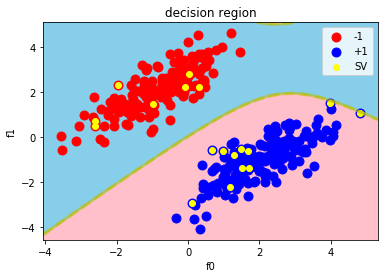

In [69]:
# スクラッチモデルの可視化
decision_region(X_train, y_train, scratch_svc, 
                sv=scratch_svc.X_sv, xlabel='f0', ylabel='f1', target_names=['-1', '+1'])

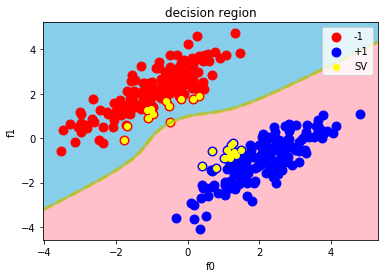

In [94]:
# sklearnモデルの可視化
decision_region(X_train, y_train, sk_svc, 
                sv=sk_svc.support_vectors_, xlabel='f0', ylabel='f1', target_names=['-1', '+1'])